In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json

# For data vasualisation, source: https://www.kaggle.com/code/alexisbcook/hello-seaborn
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pymongo import MongoClient
# change this setting to use backup data-files in data folder
use_mongodb=True

if use_mongodb:
    client = MongoClient('mongodb://localhost:27017')
    db = client["bollore_analysis_db"]
    collection = db["timeseries_data_files"]
else:
    import os
    for dirname, _, filenames in os.walk('data'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

In [2]:
import request_data_av_with_mongodb

# Function to load data and reformat it as a pandas df
def load_timeseries_as_df(ticker="BOL_PA", start_date='2021-09-21', use_mongodb=True):
    if use_mongodb:
        # Check data & update if necessary
        request_data_av_with_mongodb.main()
        # Read data from database
        data = collection.find_one({'_id': f'{ticker}.json'})["data"]
    else:
        with open(f'data/{ticker}.json') as json_file:
            data = json.load(json_file)
    
    timeseries_data = data["Time Series (Daily)"]

    df = pd.DataFrame(timeseries_data)
    df = df.transpose()
    
    # Backfill to start date with zeros
    date_range = pd.date_range(start=start_date, end=df.index.min(), freq='D')
    zero_df = pd.DataFrame(index=date_range, columns=df.columns).fillna(0).infer_objects()[::-1]
    df = pd.concat([df, zero_df])  
    
    # filter dates to relevant timeperiod
    df.index = pd.to_datetime(df.index)
    start_date = pd.to_datetime(start_date)
    df = df[df.index >= start_date]
            
    return df   

Connected at mongodb://localhost:27017


In [3]:
# Originally only used data from '2021-09-21' - (UMG IPO)
# Options:
default_post_umg_spin = '2021-09-21' # post UMG spin
after_havas_transferred = "2016-09-22" # after Havas transferred to vivendi

start_date= after_havas_transferred

bol_df = load_timeseries_as_df(ticker="BOL_PA", start_date=start_date, use_mongodb=use_mongodb)
odet_df = load_timeseries_as_df(ticker="ODET_PA", start_date=start_date, use_mongodb=use_mongodb)
umg_df = load_timeseries_as_df(ticker="UMG_AMS", start_date=start_date, use_mongodb=use_mongodb)
viv_df = load_timeseries_as_df(ticker="VIV_PA", start_date=start_date, use_mongodb=use_mongodb)

last data request: 443763.696505s
A new request is being made.
updated data for BOL.PA
updated data for ODET.PA
updated data for UMG.AMS
updated data for VIV.PA
last data request: 7.347556s
Data up to date
Next request in  86392.652444 s
last data request: 7.484653s
Data up to date
Next request in  86392.515347 s
last data request: 7.50934s
Data up to date
Next request in  86392.49066 s


C:\Users\perso\AppData\Local\Temp\ipykernel_23052\2042272725.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  zero_df = pd.DataFrame(index=date_range, columns=df.columns).fillna(0).infer_objects()[::-1]


In [4]:
#Valuation logic (classes)
class Company:   
    def __init__(self, name, shares_outstanding, shareprice, currency='€'):
        self.name = name
        self.shares_outstanding = shares_outstanding
        self.shareprice = shareprice
        self.currency = currency

        #initialising values
        self.assets = []
        self.value = 0  
        self.discount_to_value_percent = 0
        self.outputs = {'assets': []}

        #updates .outputs with formatted values
        self.update_outputs()
     
    def market_cap(self, to_string=False):
        mkt_cap = self.shares_outstanding * self.shareprice
        if to_string:
            mkt_cap = Company.large_number_to_string(mkt_cap)
        return mkt_cap
    
    def asign_asset(self, asset, value='optional', is_company_object=False, ownership_fraction=1):
        if is_company_object:
            value_of_asset = asset.market_cap() * ownership_fraction
            name_of_asset = asset.name
        else:
            value_of_asset = value
            name_of_asset = asset
        
        self.assets += [{
            'name': name_of_asset,
            'ownership_percentage': ownership_fraction,
            'value': value_of_asset
            }]
        self.outputs['assets'] += [{
            'name': name_of_asset,
            'ownership_percentage': Company.fraction_to_percentage_string(ownership_fraction),
            'value': Company.large_number_to_string(value_of_asset)
            }]    
        self.value += value_of_asset
        self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))        
        self.update_outputs()

    def update_outputs(self):
        #should change this to use add_output! so that it overwrites old values
        new_outputs = {
            'name': self.name,
            'title': str(self),
            'market_cap': self.market_cap(to_string=True),
            'shares_outstanding': Company.large_number_to_string(self.shares_outstanding),
            'value': Company.large_number_to_string(self.value),
            'currency': self.currency,
            'share_price': self.shareprice
        }
        self.add_output(new_outputs)

    def add_output(self, new_outputs):
        self.outputs.update(new_outputs)

    def __str__(self):
        return f'{self.name} (mkt cap {self.market_cap(to_string=True)} @ {self.shareprice} per share)'
    
    @staticmethod
    def large_number_to_string(value):
        if value > 1000000000:
            value = f"{str(round(value/1000000000,1))}B"
        else:
            value = f"{str(int(round(value/1000000,0)))}M"
        return value
    
    @staticmethod
    def fraction_to_percentage_string(value):
        percentage_string = ''
        if value > 0.10:
            percentage_string = f'{int(round(value * 100, 0))}%'
        else:
            percentage_string = f'{round(value * 100, 1)}%'
        return percentage_string

class CircularOwnership:

    def __init__(self, company_1, company_1_outside_ownership, company_2, company_2_outside_ownership):
        # assumes all shares not held by outside owners are cross-held
        self.company_1 = company_1
        self.company_2 = company_2
        self.companies = [company_1, company_2]
        self.company_1_outside_ownership = company_1_outside_ownership
        self.company_2_outside_ownership = company_2_outside_ownership
        self.company_1_owned_by_company_2 = 1 - company_1_outside_ownership
        self.company_2_owned_by_company_1 = 1 - company_2_outside_ownership
        self.unassigned_assets_from_company_1 = company_1.value
        self.unassigned_assets_from_company_2 = company_2.value

        #initialising values
        self.assets_owned_by_company_1_outside_shareholders = 0
        self.assets_owned_by_company_2_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_1_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = 0

        self.distribution_of_assets_iterative()
        self.update_outputs_of_subsidiaries()

    # def distribution_of_assets_analytical(self):
    #     """
    #     - analytical solution - only for a simplified case where company_1 owns all assets
    #     """
    #     self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.company_1_outside_ownership / (1 - (self.company_1_owned_by_company_2 * self.company_2_owned_by_company_1))

    #     self.proportion_of_assets_owned_by_company_2_outside_shareholders = (
    #         self.company_2_outside_ownership * self.company_1_owned_by_company_2
    #         / (1 - (self.company_2_owned_by_company_1 * self.company_1_owned_by_company_2))
    #     )

    #     print(f'Proportion Of Assets Owned By {self.company_1.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_1_outside_shareholders, f'Proportion Of Assets Owned By {self.company_2.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_2_outside_shareholders)

    def distribution_of_assets_iterative(self):
        total_assets = self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2 + self.assets_owned_by_company_1_outside_shareholders + self.assets_owned_by_company_2_outside_shareholders

        while (self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2) > 0.1:
            #section 1 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

            #section 2 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

        self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.assets_owned_by_company_1_outside_shareholders / total_assets
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = self.assets_owned_by_company_2_outside_shareholders / total_assets

        # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.assets_owned_by_company_2_outside_shareholders}')

    def update_outputs_of_subsidiaries(self):
        add_to_company_1_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_1_outside_ownership)}',
            'cross_holding_description': f'Owns {Company.fraction_to_percentage_string(self.company_2_owned_by_company_1)} of {self.company_2.name} →',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_1_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_1_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_1.market_cap() * self.company_1_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)}',
            'discount_num': -(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)
        }
        add_to_company_2_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_2_outside_ownership)}',
            'cross_holding_description': f'← Owns {Company.fraction_to_percentage_string(self.company_1_owned_by_company_2)} of {self.company_1.name}',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_2_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_2_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_2.market_cap() * self.company_2_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)}',
            'discount_num': -(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)

        }
        
        self.company_1.add_output(add_to_company_1_ouputs)
        self.company_2.add_output(add_to_company_2_ouputs)
        

    def __str__(self):
        return f'{self.company_1} owns {round(self.company_2_owned_by_company_1 * 100,3)}% of {self.company_2} and {self.company_2} owns {round(self.company_1_owned_by_company_2 * 100,3)}% of {self.company_1}'


In [5]:
# assigns assets, 
def main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    # Bollore 'galaxy'
    bollore = Company('Bolloré SE', shares_outstanding=(2902650243 - 99.1 * 10 ** 6) , shareprice=bollore_shareprice)
    umg = Company('Universal Music Group', shares_outstanding=1.81 * 10 ** 9, shareprice=umg_shareprice)
    odet = Company("Compagnie de l'Odet", shares_outstanding=6590000, shareprice=odet_shareprice)
    vivendi = Company("Vivendi", shares_outstanding=1139051437, shareprice=vivindi_shareprice)

    # Asign Assets
    bollore.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.1810) # was 17.7%, cash flow statement implies they've been buying
    odet.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.0033)
    bollore.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.29)
    odet.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.005)
    bollore.asign_asset('Cash', (1.415*10**9)) #source - 'liquidity'
    bollore.asign_asset('Expected proceeds from sale of Bolloré logistics', 4.65*10**9) # 4.65B euros, prior to net cash/debt

    bollore_odet_group = CircularOwnership(company_1=bollore, company_1_outside_ownership=0.292, company_2=odet, company_2_outside_ownership=0.16)
    
    return bollore, umg, odet, vivendi, bollore_odet_group

def odet_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return odet.outputs["discount_num"]

def bollore_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return bollore.outputs["discount_num"]

In [6]:
half1_df = pd.merge(bol_df, odet_df, left_index=True, right_index=True, suffixes=('_bol', '_odet'))
half2_df = pd.merge(umg_df, viv_df, left_index=True, right_index=True, suffixes=('_umg', '_viv'))
main_df = pd.merge(half1_df, half2_df, left_index=True, right_index=True)

main_df = main_df.apply(pd.to_numeric, errors='coerce')

#switching from kaggle to VSCode, needed to reverse dataframe vertically here
main_df= main_df.iloc[::-1]

print("---data merged---")

---data merged---


In [7]:
# Calculate the valuation discount for each of Odet & Bollore

# choose what time of day to pick data from
time_price = "4. close"

# Can use apply method to apply the function to each row:
main_df["discount_odet"] = main_df.apply(lambda row: odet_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_bol"] = main_df.apply(lambda row: bollore_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)

# OLD DISCOUNT RATIO - 
# main_df["discount_ratio"] = 1 - main_df["discount_odet"] / main_df["discount_bol"]

# Correct measure: additional discount of Odet relative to Bollore valuation
main_df["discount_ratio"] = -(1 - (1 + main_df["discount_odet"]) / (1 + main_df["discount_bol"]))

# although mainly focussed on discount, Odet/Bollore price ratio is probably a useful feature too?
# REMOVED: after correcting discount calculation price ratio was co-linear with discount ratio over, so removed as a redundant feature
"""
normalisation_factor = main_df[time_price + "_odet"].mean() / main_df[time_price + "_bol"].mean()
main_df["price_ratio"] = (main_df[time_price + "_odet"] / main_df[time_price + "_bol"]) / normalisation_factor
"""

# print(main_df.head())

C:\Users\perso\AppData\Local\Temp\ipykernel_23052\3926679014.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))
C:\Users\perso\AppData\Local\Temp\ipykernel_23052\3926679014.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))


'\nnormalisation_factor = main_df[time_price + "_odet"].mean() / main_df[time_price + "_bol"].mean()\nmain_df["price_ratio"] = (main_df[time_price + "_odet"] / main_df[time_price + "_bol"]) / normalisation_factor\n'

<Axes: >

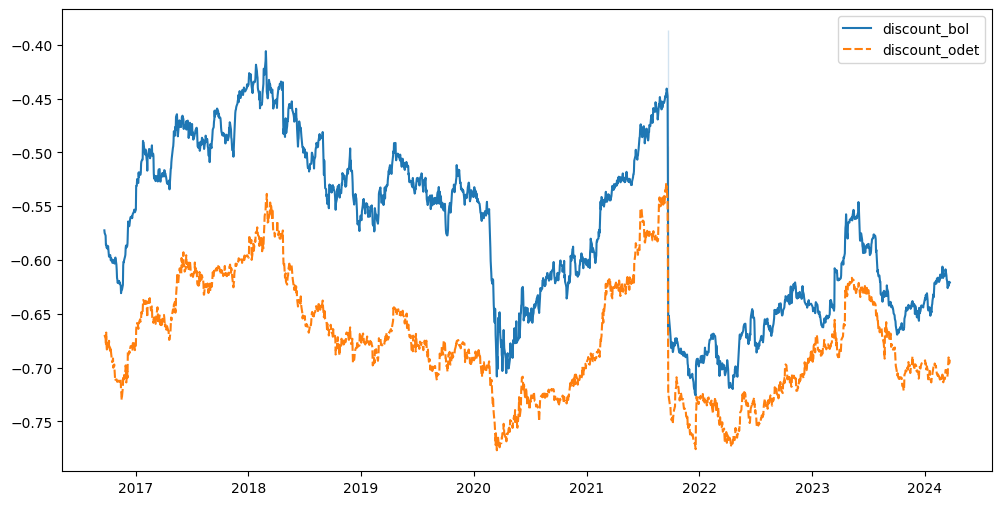

In [8]:
# Data visualisation, starting code - https://www.kaggle.com/code/alexisbcook/hello-seaborn
# Set the width and height of the figure
plt.figure(figsize=(12,6))

sns.lineplot(data=main_df[["discount_bol", "discount_odet"]])

discount range: -0.051141291423697055 -0.3720863089015506
median & mean: -0.2447479469533433 -0.23376492963054768 standard deviation 0.06607343167385808


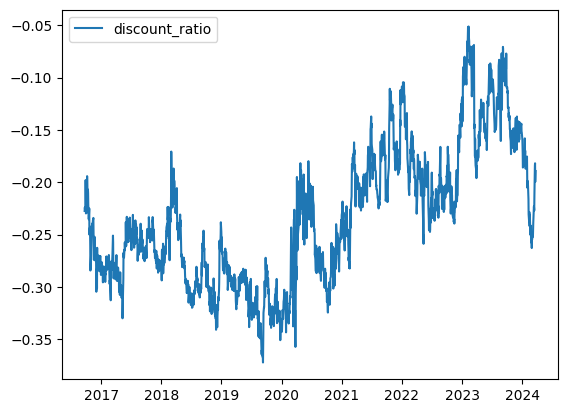

In [9]:
columns_to_plot = ["discount_bol", "discount_odet", "discount_ratio"]

# co-plot discounts & relative discount:
# fig, ax1 = plt.subplots(figsize=(12, 6))

# sns.lineplot(data=main_df[columns_to_plot[:2]], ax=ax1)

# ax2 = ax1.twinx()

# sns.lineplot(data=main_df[columns_to_plot[2]], ax=ax2, color='grey')

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Discount Bol & Odet', color='blue')
# ax2.set_ylabel('Discount Ratio', color='grey')
# plt.title('Discounts and Ratio over Time')

# plot just relative discount:

sns.lineplot(data=main_df[["discount_ratio"]])

print("discount range:",main_df["discount_ratio"].max(), main_df["discount_ratio"].min())
print("median & mean:", main_df["discount_ratio"].median(), main_df["discount_ratio"].mean(),"standard deviation", main_df["discount_ratio"].std())

In [10]:
# generalised function for approach used below
def remove_columns_starting_with(start_df, prefixes_to_remove):
    columns_to_remove = [col for col in start_df.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]
    return_df = start_df.drop(columns=columns_to_remove)
    return return_df

**Open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis**

In [11]:
# Feature engineering (feature selection)
# Removing all columns for open/high/low price for now (so we can focus on closing price)
columns_to_remove = [col for col in main_df.columns if any(col.startswith(prefix) for prefix in ('1. open', '2. high', '3. low', '5. volume'))]
# if col.startswith('1. open') or col.startswith('2. high') ... would have been alternate approach

end_day_df = main_df.drop(columns=columns_to_remove)
#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

end_day_df.head()

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio
2016-09-22,3.218,751.0,0.0,7.4221,-0.669675,-0.572466,-0.227372
2016-09-23,3.200,750.0,0.0,7.4304,-0.670223,-0.574995,-0.224062
2016-09-26,3.168,740.0,0.0,7.3147,-0.673128,-0.577330,-0.226650
2016-09-27,3.099,725.1,0.0,7.2837,-0.679316,-0.586031,-0.225343
2016-09-28,3.112,754.0,0.0,7.3560,-0.667488,-0.585475,-0.197849


In [12]:
# Check Correlation Matrix:
correlation_matrix = end_day_df.corr() #main_df.corr()
correlation_matrix

#NOTE - open/close/high/low shareprices had extremely close correlation to one another (>=0.99) & highly associated in PCA, so removed to simplify the analysis

,4. close_bol,4. close_odet,4. close_umg,4. close_viv,discount_odet,discount_bol,discount_ratio
4. close_bol,1.000000,0.964931,0.788955,0.193669,0.159725,-0.143848,0.639782
4. close_odet,0.964931,1.000000,0.842921,0.176206,0.104429,-0.275984,0.816055
4. close_umg,0.788955,0.842921,1.000000,0.091491,-0.423585,-0.699710,0.735719
4. close_viv,0.193669,0.176206,0.091491,1.000000,-0.045102,-0.104546,0.122134
discount_odet,0.159725,0.104429,-0.423585,-0.045102,1.000000,0.885590,-0.019017
discount_bol,-0.143848,-0.275984,-0.699710,-0.104546,0.885590,1.000000,-0.477034
discount_ratio,0.639782,0.816055,0.735719,0.122134,-0.019017,-0.477034,1.000000


<Axes: >

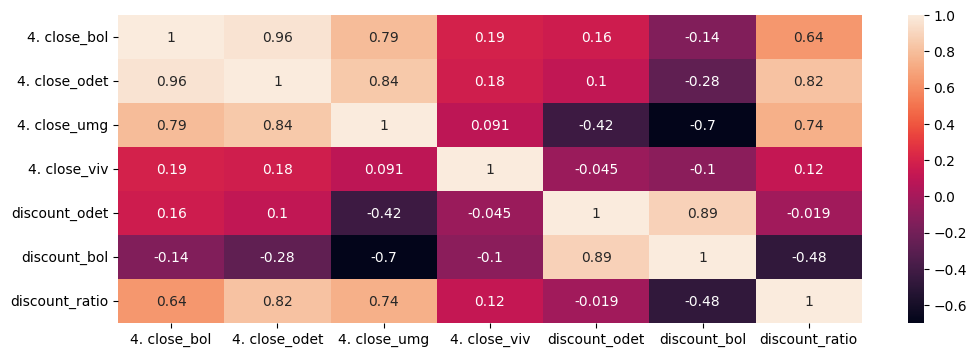

In [13]:
plt.figure(figsize=(12,4))
sns.heatmap(correlation_matrix, annot=True)

# Interesting observations
* Discount_ratio is most closely correlated with UMG stock price (surprising) & has limmited correlation with discount_odet (surprising).
* Otherwise discount_ratio shows some correlation with ODET price (not much with BOL), and some with discount_bol (but not much with discount_odet)
* Volumes don't seem to be closely correlated with anything significant & mostly correlate with one another.

In [14]:
# profit from buying Odet and Selling Bollore
def trading_profit(odet_new, odet_old, bol_new, bol_old, method=1):
    
    # Method 1: profit multiplier, buying odet and shorting bollore over the timeperiod
    if (method == 1):
        return (
        1 + (( odet_new / odet_old)
        -
        ( bol_new / bol_old)
        ))
    
    # Method 2: profit ratio, buying odet compared to buying bollore
    elif (method == 2):
        return (
        (odet_new / odet_old) / (bol_new / bol_old)
        )
    

In [15]:
# Target variable - goal is to figure out whether available information can provide good signals for trading the ODET / BOL pair.
# As a first attempt at a target variable I'm going to propose relative profit/loss from buying ODET & selling BOL & holding for set number of days

# Shift the values of the desired column 60 days ahead
days_ahead = 120

dummy_df = pd.DataFrame()
dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] = main_df[time_price + "_odet"].shift(+ days_ahead)
dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] = main_df[time_price + "_bol"].shift(+ days_ahead)

# NEW: - attempts to use generalised function appeared to work, but caused some errors
"""
main_df[f'trading_profit_{days_ahead}_days_frctn'] = main_df.apply(
    lambda row: -1 + trading_profit(
        odet_new= dummy_df.loc[row.name, f'price_{days_ahead}_days_ahead' + '_odet'],
        odet_old= row[time_price + "_odet"],
        bol_new= dummy_df.loc[row.name, f'price_{days_ahead}_days_ahead' + '_bol'],
        bol_old= row[time_price + "_bol"],
        method=1
    ),
    axis=1
)
"""

# OLD: - functions reliably
main_df[f'trading_profit_{days_ahead}_days_frctn'] = (
    ( dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] / main_df[time_price + "_odet"]) -
    ( dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] / main_df[time_price + "_bol"])
    )

# number of rows=days_ahead of NaN need to be dropped for data to be useful for machine learning later (data wrangling)
main_df = main_df.dropna()

print("---")

---


In [16]:
# PCA:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

# 1st select and standardise data:

X = main_df.copy().drop(columns=columns_to_remove) #removes 'wrong' time of day
# X = remove_columns_starting_with(start_df=X, prefixes_to_remove=("5. volume"))

y = X.pop(f'trading_profit_{days_ahead}_days_frctn')

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [17]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)


In [18]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
4. close_bol,0.431746,0.339542,0.008942,0.478926,-0.257724,-0.266874,-0.575511
4. close_odet,0.474467,0.289337,-0.006910,0.087732,-0.407334,0.406745,0.593345
4. close_umg,0.503583,-0.100198,-0.097679,0.243644,0.789595,-0.068729,0.198184
4. close_viv,0.057089,-0.025313,0.994958,0.016995,0.073132,0.005531,0.022181
discount_odet,-0.151370,0.687257,0.016959,-0.234243,0.130154,-0.581006,0.308381
discount_bol,-0.334212,0.549726,0.006672,0.175702,0.339631,0.624954,-0.221971
discount_ratio,0.443859,0.125674,-0.007652,-0.785837,0.080986,0.174492,-0.364129


<Axes: >

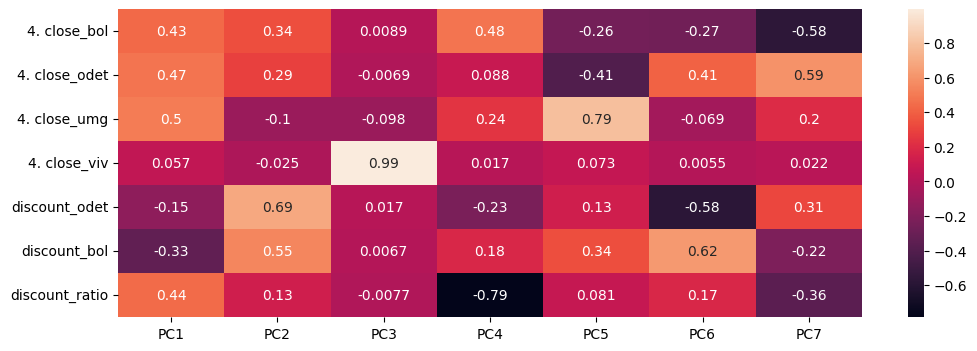

In [19]:
plt.figure(figsize=(12,4))
sns.heatmap(loadings, annot=True)

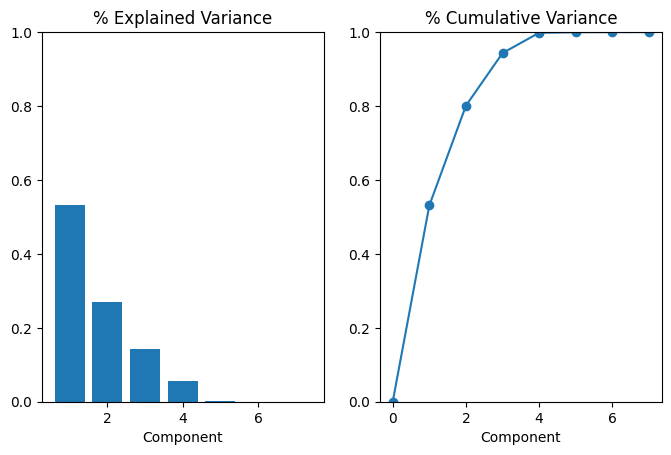

In [20]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

# Initial attempts at random forest to explore which variables are important for predicting whether trades profitable/unprofitable
example code source = https://www.kaggle.com/code/alexisbcook/machine-learning-competitions/tutorial

In [21]:
##### Import helpful libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split # Not appropriate for this temporal dataset

# Need to split as timeseries:
from sklearn.model_selection import TimeSeriesSplit

# Separate the target
# I've already defined X and y for the PCA model, will use those for now.

#choose whether to include synthetic features related to price & discount
remove_features = False
if (remove_features):
    X = remove_columns_starting_with(X, ("price", "discount")) # test model without synthetic features

#probably wise to remove price data eventually, since this is likely to lead to overfitting without providing predictive power over a longer timeframe
remove_original_prices = False
if (remove_original_prices):
    X = remove_columns_starting_with(X, ("4. close")) # test model without original prices
    
# new synthetic features:
add_upper_lower_thresholds = False
if (add_upper_lower_thresholds):
    threshold_upper = X["discount_ratio"].median() - X["discount_ratio"].std()
    threshold_lower = X["discount_ratio"].median() + X["discount_ratio"].std()
#     threshold_upper = -0.11
#     threshold_lower = -0.06

    X['discount_wide'] = np.where(X['discount_ratio'] < threshold_upper, 1, 0)
    X['discount_narrow'] = np.where(X['discount_ratio'] > threshold_lower, 1, 0)    
    
# Instead:
# Create TimeSeriesSplit object - n_splits: number "folds"
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over the splits
for train_index, val_index in tscv.split(X):
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    
for train_index, val_index in tscv.split(y):
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
# .fit model initially returned error - input y contained NaN (before I ran main_df.dropna() )
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print(f'Validation MAE for Random Forest Model (%): {(rf_val_mae * 100).round(3)}')
print("Average absolute change (trading) in validation set",(val_y.abs().mean() * 100).round(3), "%")

# Applying model to datapoints significantly deviating from mean.

std_y = val_y.std()
mean_y = val_y.abs().mean()
outer_std_deviations_y = val_y[(val_y > mean_y + std_y) | (val_y < mean_y - std_y)]
outer_std_devaitions_X = val_X[(val_y > mean_y + std_y) | (val_y < mean_y - std_y)]

rf_outer_std_deviations_predictions = rf_model.predict(outer_std_devaitions_X)
rf_outer_std_deviations_mae = mean_absolute_error(rf_outer_std_deviations_predictions, outer_std_deviations_y)
print("-----")
print("After filtering for outer std deviations:")
print(f'Filterred: Validation MAE for Random Forest Model (%): {(rf_outer_std_deviations_mae * 100).round(3)}')
print("Filterred: Average absolute change (trading) in validation set",(outer_std_deviations_y.abs().mean() * 100).round(3), "%")
print("Datapoints in filtered set:", len(outer_std_deviations_y), "  Datapoints in unfiltered validation set:", len(val_y))

Validation MAE for Random Forest Model (%): 8.321
Average absolute change (trading) in validation set 6.993 %
-----
After filtering for outer std deviations:
Filterred: Validation MAE for Random Forest Model (%): 4.654
Filterred: Average absolute change (trading) in validation set 9.385 %
Datapoints in filtered set: 144   Datapoints in unfiltered validation set: 300


* **Temporal data, with consecutive time points highly likely to be correlated. A simple random split using train_test_split doesn't appear to be suitable.**
* **Swapping trading time perdiod from 60 -> 120 days seems to reduce MAE considerably (initial timeperiod)**
suggests either - better predictive power over longer time period (expected), data leakage (longer timeframe makes data spillover between slices more likely) or overfitting by chance.

Results for data post UMG IPO:
Calculations using previous older measure for relative discount
Using post UMG spin data (best quality, but relatively limmited timeperiod)

**For trading time = 120 days, with just stock prices (no synthetic variables), TimeSeriesSplit(n_splits=10)**
* Validation MAE for Random Forest Model (%): 3.577 --- (3.445% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variable: "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.699
* Average absolute change (trading) in validation set 4.615 %

**Adding only synthetic variables: "discount_odet", "discount_bol", "discount_ratio" (NOT "price_ratio)**
* Validation MAE for Random Forest Model (%): 2.718
* Average absolute change (trading) in validation set 4.615 %

**Adding synthetic variables: "discount_odet", "discount_bol", "discount_ratio", "price_ratio"**
* Validation MAE for Random Forest Model (%): 2.357
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from discount ratio): "discount_wide", "discount_narrow"**
* Validation MAE for Random Forest Model (%): 2.268 --- (2.272% with volumes)
* Average absolute change (trading) in validation set 4.615 %

**Adding further synthetic variables (derived from price ratio): "price_ratio_high", "price_ratio_low"**
* Validation MAE for Random Forest Model (%): 2.422     //-> significantly worse
* Average absolute change (trading) in validation set 4.615 %

*overall, volumes don't appear to make much difference either way, so have chosen to remove for improved interpretability*


In [22]:
print("trading profit, max:",y.max(),"mean:", y.mean(),"std:", y.std())
print("------------------------")
dummy_df_2=pd.concat([X, y],axis=1)

def average_profit(discount_description, value, df=dummy_df_2):
    df = df[df["discount_" + discount_description] == value]
    return df["trading_profit_120_days_frctn"].mean()
    
# print(average_profit("wide", 1), average_profit("narrow", 1))
# print(average_profit("wide", 0), average_profit("narrow", 0))

trading profit, max: 0.21225152293750993 mean: -0.005960174459783474 std: 0.07523646521076782
------------------------


<Axes: >

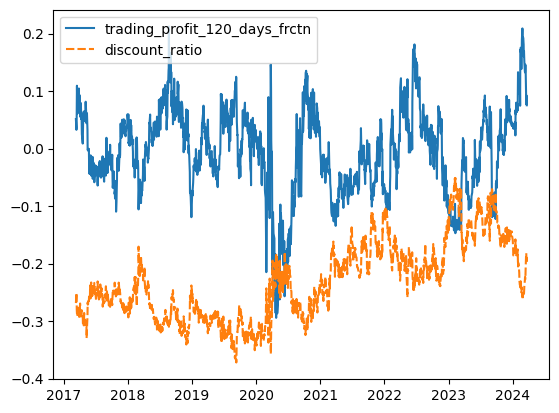

In [23]:
sns.lineplot(data=dummy_df_2[["trading_profit_120_days_frctn","discount_ratio"]])

<Axes: >

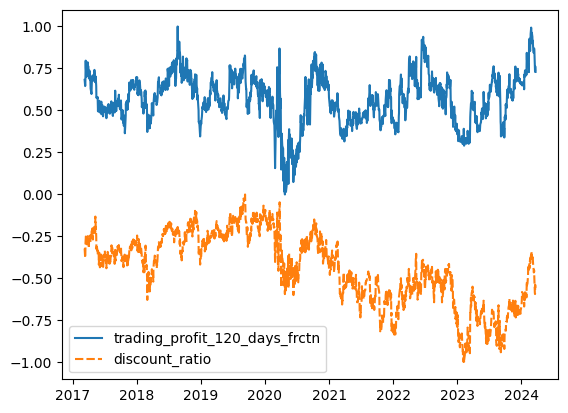

In [24]:
def normalise(df):
    return (df - df.min()) / (df.max() - df.min())


dummy_df_3 = normalise(main_df.copy())
dummy_df_3["discount_ratio"] = -dummy_df_3["discount_ratio"]
sns.lineplot(data=dummy_df_3[["trading_profit_120_days_frctn","discount_ratio"]])

In [25]:
# Tensor flow & keras - starting code from: https://www.kaggle.com/code/ryanholbrook/binary-classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from tensorflow import keras
from tensorflow.keras import layers

# Setup plotting
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid') # caused error (deprecated?)
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


In [26]:
# Engineer a new binary feature determining whether or not to trade
y_new = y.apply(lambda x: 1 if x >= 0.00 else 0)

# Instead:
# Create TimeSeriesSplit object - n_splits: number "folds"
tscv = TimeSeriesSplit(n_splits=5)

# Iterate over the splits
for train_index, val_index in tscv.split(X):
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    
for train_index, val_index in tscv.split(y_new):
    train_y, val_y = y_new.iloc[train_index], y_new.iloc[val_index]

c:\programming\bollore-data-project\venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.6482 - loss: 0.7859 - val_binary_accuracy: 0.5367 - val_loss: 0.7481
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7535 - loss: 0.5849 - val_binary_accuracy: 0.5367 - val_loss: 0.7442
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7177 - loss: 0.5379 - val_binary_accuracy: 0.5367 - val_loss: 0.7286
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7796 - loss: 0.5114 - val_binary_accuracy: 0.5367 - val_loss: 0.7170
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7683 - loss: 0.4906 - val_binary_accuracy: 0.5367 - val_loss: 0.7117
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7694 - loss: 0.4748 - val_binary_accuracy: 0.5367 - val_loss: 0.7190
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7900 - loss: 0.4800 - val_binary_accuracy: 0.5367 - val_loss: 0.7116
Epoch 8/300


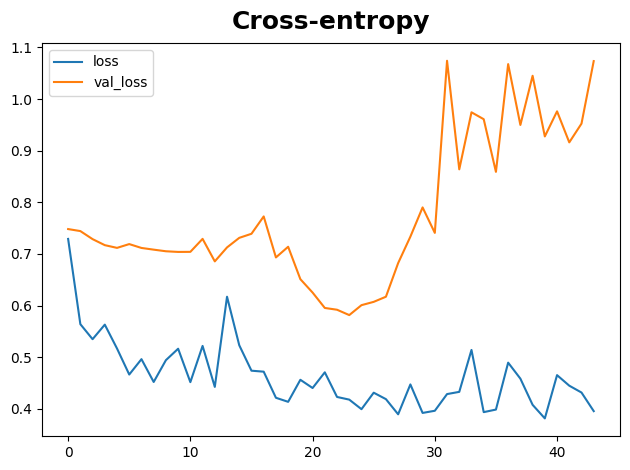

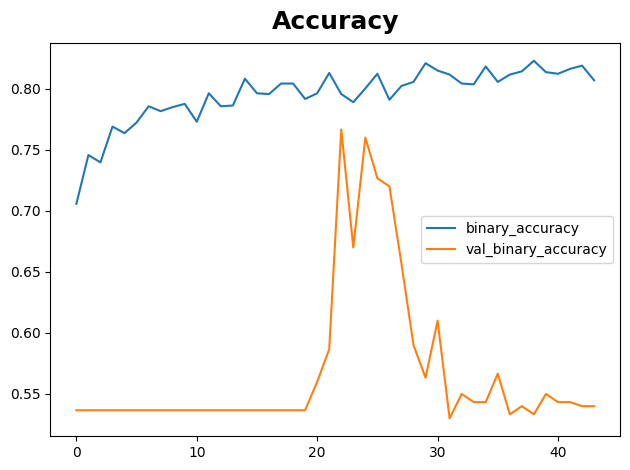

In [27]:
input_shape = [X.shape[1]]

activation_method="sigmoid"#"relu"#

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    #--------------------------
    layers.Dense(200, activation=activation_method),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    

    layers.Dense(1, activation="sigmoid"),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

#Checks
print("total +ves in val_sample:",val_y.sum())
print("total size of val_sample:",val_y.size)
print(y_new.sum())
print(y_new.size)


# Backtesting

In [28]:
#null-functions (trade every opportunity)
def strategy_buy_default(row):
    return True

def strategy_sell_default(row):
    return True

# as currently set up backtests using absolute price
# takes into account the overal trend in the Bol/Odet stockprice
# not just relative valuation as intended
def backtest(strategy_buy, strategy_sell, df, trading_costs = 0):
    #starting state
    owned = "none"
    old = "NA"
    profit_ratios = []    
    
    for index, row in df.iterrows():
        if (owned != "_bol" and strategy_sell(row)):
            if (old != "NA"):
                # calculate profit ratio
                new = row["4. close" + owned]
                profit_ratio = (new / old) - trading_costs
                
                profit_ratios.append(profit_ratio)
            
            # set new state
            owned = "_bol" #buying this
            old = row["4. close" + owned]
            
        elif (owned != "_odet" and strategy_buy(row)):
            if (old != "NA"):
                # calculate profit ratio
                new = row["4. close" + owned]
                profit_ratio = (new / old) - trading_costs
                
                profit_ratios.append(profit_ratio)
                
            # set new state
            owned = "_odet" # buying this
            old = row["4. close" + owned]
        #--------------------------------
    print("absolute profit",np.prod(profit_ratios))
    return pd.DataFrame(profit_ratios)

#------------------------------------------------------------------------

def backtest_relative(strategy_buy, strategy_sell, df, trading_costs = 0):
    # GOAL: adjust function to give RELATIVE profit ratios and ignore long-term trend in overal price for the Bol/Odet pair!    
    
    # profit from buying Odet and Selling Bollore
    def trading_profit(odet_new, odet_old, bol_new, bol_old):
        return (
        1 + (( odet_new / odet_old)
        -
        ( bol_new / bol_old)
        ))
        
    #starting state
    owned = "none"
    old = "NA"
    profit_ratios = []    
    
    for index, row in df.iterrows():
        # buying bol
        if (owned != "_bol" and strategy_sell(row)):
            if (owned != "none"):
                # calculate profit ratio
                odet_new = row["4. close" + "_odet"]
                bol_new = row["4. close" + "_bol"]
                profit_ratio = trading_profit(odet_new, odet_old, bol_new, bol_old) - trading_costs
                
                profit_ratios.append(profit_ratio)
            
            # set new state
            owned = "_bol" #buying this
            odet_old = row["4. close" + "_odet"]
            bol_old = row["4. close" + "_bol"]
        
        # buying odet
        elif (owned != "_odet" and strategy_buy(row)):
            if (owned != "none"):
                # calculate profit ratio
                odet_new = row["4. close" + "_odet"]
                bol_new = row["4. close" + "_bol"]
                profit_ratio = 1/trading_profit(odet_new, odet_old, bol_new, bol_old) - trading_costs
                
                profit_ratios.append(profit_ratio)
                
            # set new state
            owned = "_odet" # buying this
            odet_old = row["4. close" + "_odet"]
            bol_old = row["4. close" + "_bol"]
        #--------------------------------
    print("relative profit multiplier (to inverse strategy)",np.prod(profit_ratios))
    return pd.DataFrame(profit_ratios)

In [29]:
# moving averages
# consider incorporating some of these as features:
number_days_ma = 80

y_ma = main_df["discount_ratio"].rolling(number_days_ma, center=False).mean()
y_std = main_df["discount_ratio"].rolling(number_days_ma, center=False).std()

# reasonable starting point for a strategy:
weighting = 1.5 #default 1.5
y_sell = y_ma + y_std * weighting
y_buy = y_ma - y_std * weighting

main_df["mean_ma"] = y_ma
main_df[f"upper_{weighting}_std_bound_ma"] = y_sell
main_df[f"lower_{weighting}_std_bound_ma"] = y_buy


print(y_ma)
print(main_df.head())


2017-03-10         NaN
2017-03-13         NaN
2017-03-14         NaN
2017-03-15         NaN
2017-03-16         NaN
                ...   
2024-03-18   -0.192420
2024-03-19   -0.192962
2024-03-20   -0.193520
2024-03-21   -0.193966
2024-03-22   -0.194219
Name: discount_ratio, Length: 1802, dtype: float64
            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2017-03-10        3.560        3.605       3.560         3.560        1226167   
2017-03-13        3.547        3.580       3.520         3.536        1511035   
2017-03-14        3.528        3.530       3.485         3.510        1025563   
2017-03-15        3.522        3.546       3.499         3.521        1071856   
2017-03-16        3.548        3.601       3.532         3.577        1361428   

            1. open_odet  2. high_odet  3. low_odet  4. close_odet  \
2017-03-10        780.25        786.25       770.00         786.25   
2017-03-13        786.30        800.00       774.95         800.00   

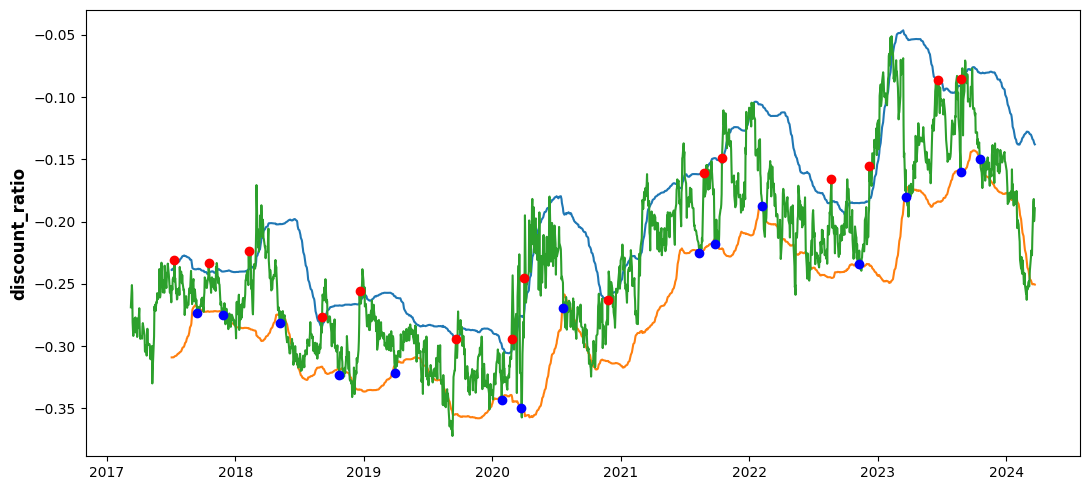

In [30]:


plt.figure(figsize=(11, 5))
# sns.lineplot(data=y_ma)
# sns.lineplot(data=y_std)
sns.lineplot(data=y_sell)
sns.lineplot(data=y_buy)
sns.lineplot(data=main_df["discount_ratio"])
      
owned = "null"
for i in range(1, len(main_df)):
    if (main_df["discount_ratio"].iloc[i] >= main_df[f"upper_{weighting}_std_bound_ma"].iloc[i-1] and 
        main_df["discount_ratio"].iloc[i-1] < main_df[f"upper_{weighting}_std_bound_ma"].iloc[i] and 
        owned != "bol"):
        plt.scatter(main_df.index[i], main_df["discount_ratio"].iloc[i], color='red', zorder=5)
        owned = "bol"
    elif (main_df["discount_ratio"].iloc[i] <= main_df[f"lower_{weighting}_std_bound_ma"].iloc[i-1] and 
          main_df["discount_ratio"].iloc[i-1] > main_df[f"lower_{weighting}_std_bound_ma"].iloc[i] and 
          owned != "odet"):
        plt.scatter(main_df.index[i], main_df["discount_ratio"].iloc[i], color='blue', zorder=5)
        owned = "odet"



"""
owned = "null"
for i in range(1, len(main_df)):
    if (main_df["discount_ratio"].iloc[i] >= y_sell[i-1] and main_df["discount_ratio"].iloc[i-1] < y_sell[i] and owned != "bol"):
        plt.scatter(main_df.index[i], main_df["discount_ratio"].iloc[i], color='red', zorder=5)
        owned = "bol"
    elif (main_df["discount_ratio"].iloc[i] <= y_buy[i-1] and main_df["discount_ratio"].iloc[i-1] > y_buy[i] and owned != "odet"):
        plt.scatter(main_df.index[i], main_df["discount_ratio"].iloc[i], color='blue', zorder=5)
        owned = "odet"
"""
        
backtest_df = main_df.dropna()


In [31]:
trading_costs = 0.003

print("baseline, trade every opportunity:")
null_strategy = backtest_relative(strategy_buy_default, strategy_sell_default, backtest_df, trading_costs)
print(len(null_strategy))
print(null_strategy.mean())

def strategy_buy(row):
    return row["discount_ratio"] < row[f"lower_{weighting}_std_bound_ma"] 

def strategy_sell(row):
    return row["discount_ratio"] > row[f"upper_{weighting}_std_bound_ma"]

print(f"with strategy: buy/sell when >{weighting}sd from mean ({number_days_ma} day moving avg)")

test_strategy = backtest_relative(strategy_buy, strategy_sell, backtest_df, trading_costs)
print(len(test_strategy))
print("number profitable trades", test_strategy[test_strategy[0] >= 1].shape[0])
print("number un-profitable trades", test_strategy[test_strategy[0] <= 1].shape[0])
print("average profitability of trades:",test_strategy.mean())
print("sd of profitability of trades:", test_strategy.std())

# print(test_strategy)

print("")
absolute_returns = backtest(strategy_buy, strategy_sell, backtest_df, trading_costs)
print("")

baseline, trade every opportunity:
relative profit multiplier (to inverse strategy) 0.012500672368440697
1722
0    0.997579
dtype: float64
with strategy: buy/sell when >1.5sd from mean (80 day moving avg)
relative profit multiplier (to inverse strategy) 5.9716213626864905
29
number profitable trades 28
number un-profitable trades 1
average profitability of trades: 0    1.064387
dtype: float64
sd of profitability of trades: 0    0.042066
dtype: float64

absolute profit 3.2112855589897333



In [32]:
# beginning to explore sharpe & t-values for this data:
# source (equations): https://www.stat.berkeley.edu/~aldous/157/Papers/harvey.pdf

test_df= backtest_df
results_df= test_strategy

start_date = test_df.index[0]
end_date = test_df.index[-1]

number_of_years= (end_date - start_date).days / 365.25
number_realisations= len(results_df)
mean_profit= results_df.mean() - 1
std_deviation_profit= results_df.std()

print("Number of years:", number_of_years)
print("Number of realisations:",number_realisations)
print("Mean return per transaction:", mean_profit)
print("Std deviation of profit:", std_deviation_profit)

sharpe_ratio_annualised= (
    np.sqrt(number_realisations/number_of_years) * mean_profit 
    / std_deviation_profit
)

t_statistic= (sharpe_ratio_annualised * np.sqrt(number_of_years))

print("------------")
print("pseudo-sharpe ratio annualised:",sharpe_ratio_annualised)
print("t-statistic:",t_statistic)

SyntaxError: invalid syntax (253895821.py, line 24)

In [ ]:
# rule of thumb - don't want to trade more than 3-5% of daily volume if you want to avoid moving share-price too much
print("reasonable daily trading volumes:")
print("value of appx 5% Odet volume: €{:.0f} (max)".format(main_df["5. volume_odet"].mean() * 1400 / 20))
print("value of appx 1% Odet volume: €{:.0f} (safer)".format(main_df["5. volume_odet"].mean() * 1400 / 100))

print("")

print("--- Reference values ---")
print("1.000598 ** 1682 =", (1.000598 ** 1682), "--> any costs drive this to near-zero (negligible profitability across a huge number of trades)") # happens to be slight skew in profitability swapping randomly ^1682
print("buy and hold odet:", backtest_df[time_price + "_odet"].iloc[-1]/backtest_df[time_price + "_odet"].iloc[0])
print("buy and hold bollore:", backtest_df[time_price + "_bol"].iloc[-1]/backtest_df[time_price + "_bol"].iloc[0])

reasonable daily trading volumes:
value of appx 5% Odet volume: €28708 (max)
value of appx 1% Odet volume: €5742 (safer)

--- Reference values ---
1.000598 ** 1682 = 2.733370258940738 --> any costs drive this to near-zero (negligible profitability across a huge number of trades)
buy and hold odet: 1.6733333333333333
buy and hold bollore: 1.5175
